# Model training

In [1]:
import nltk
#nltk.download("subjectivity")
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from nltk.tokenize import SpaceTokenizer
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import numpy as np
import seaborn as sns
import re

## Tutorial part

n_instances = 100
subj_docs = [(sent, 'subj') for sent in subjectivity.sents(categories='subj')[:n_instances]]
obj_docs = [(sent, 'obj') for sent in subjectivity.sents(categories='obj')[:n_instances]]
#subj_docs[3][0]

train_subj_docs = subj_docs[:80]
test_subj_docs = subj_docs[80:100]
train_obj_docs = obj_docs[:80]
test_obj_docs = obj_docs[80:100]
training_docs = train_subj_docs+train_obj_docs
testing_docs = test_subj_docs+test_obj_docs

sentim_analyzer = SentimentAnalyzer()
all_words_neg = sentim_analyzer.all_words(training_docs,labeled= True)
#all_words_neg

unigram_feats = sentim_analyzer.unigram_word_feats(all_words_neg, min_freq=4)
sentim_analyzer.add_feat_extractor(extract_unigram_feats, unigrams=unigram_feats)
#unigram_feats

training_set = sentim_analyzer.apply_features(training_docs)
test_set = sentim_analyzer.apply_features(testing_docs)
#test_set

print(testing_docs[0][1],testing_docs[9][1],testing_docs[19][1])

#trainer = NaiveBayesClassifier.train
#classifier = sentim_analyzer.train(trainer, training_set)
NBC= NaiveBayesClassifier.train(training_set)
NBC.classify_many([test_set[0][0],test_set[9][0],test_set[19][0]])

## Formal/informal model training

In [2]:
informal_corpus= "./coca-samples-text/text_tvm.txt"
formal_corpus= "./coca-samples-text/text_news.txt"
model_name= "tvm_news"

In [3]:
# reading soap operas text
soap_file = open(informal_corpus, "r")
soap_text = soap_file.read() # string
soap_file.close()
# tokenizing sentences using punctuations
punkt_tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
soap_sentences= (punkt_tokenizer.tokenize(soap_text))
# tokenizing sentences using spaces (and removal of words containing "@")
space_tokenizer = SpaceTokenizer()
informal_docs= [] # list of tuples, tuples contain tokens and label
for sentence in soap_sentences:
    tokenized_sentence= space_tokenizer.tokenize(sentence)
    if len(tokenized_sentence)>1:
        informal_docs.append(([ele for ele in tokenized_sentence if not (re.search('[@#/<>*]', ele))],"colloquial"))

In [4]:
# reading wikipedia articles text
wiki_file = open(formal_corpus, "r")
wiki_text = wiki_file.read() # string
wiki_file.close()
# tokenizing sentences using punctuations
punkt_tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
wiki_sentences= (punkt_tokenizer.tokenize(wiki_text))
# tokenizing sentences using spaces (and removal of words containing "@")
space_tokenizer = SpaceTokenizer()
formal_docs= [] # list of tuples, tuples contain tokens and label
for sentence in wiki_sentences:
    tokenized_sentence= space_tokenizer.tokenize(sentence)
    if len(tokenized_sentence)>1: # no single word sentences
        formal_docs.append(([ele for ele in tokenized_sentence if not (re.search('[@#/<>*]', ele))],"formal"))

In [5]:
train_formal, test_formal = nltk.sentiment.util.split_train_test(formal_docs, n=None)
train_informal, test_informal = nltk.sentiment.util.split_train_test(informal_docs, n=None)
train_docs= train_formal+train_informal
test_docs= test_formal+test_informal

In [6]:
sentim_analyzer = SentimentAnalyzer()
all_words = sentim_analyzer.all_words(train_docs,labeled= True)

In [7]:
unigram_feats = sentim_analyzer.unigram_word_feats(all_words, min_freq=100)

In [8]:
sentim_analyzer.add_feat_extractor(extract_unigram_feats, unigrams=unigram_feats)

In [9]:
train_set = sentim_analyzer.apply_features(train_docs)
test_set = sentim_analyzer.apply_features(test_docs)

In [10]:
NBC= NaiveBayesClassifier.train(train_set)

In [12]:
results= []
y_pred= []
y_test= []
for i in tqdm(np.random.randint(0,len(test_set),5000)):
    y_pred.append(NBC.classify(test_set[i][0]))
    y_test.append(test_docs[i][1])
    if y_pred[-1]==y_test[-1]:
        results.append(1)
    else:
        results.append(0)
cf_matrix = confusion_matrix(y_test, y_pred)
precision= sum(results)/len(results)

100%|██████████████████████████████████████| 5000/5000 [00:30<00:00, 164.24it/s]


In [13]:
precision

0.8888

[Text(0, 0.5, 'Formal'), Text(0, 1.5, 'Colloquial')]

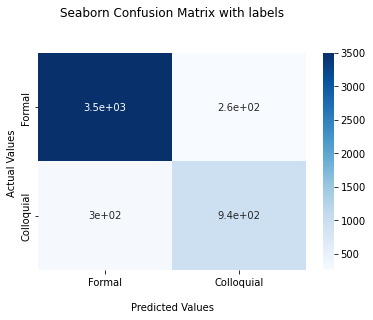

In [14]:
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Formal','Colloquial'])
ax.yaxis.set_ticklabels(['Formal','Colloquial'])

In [16]:
import pickle
with open("NBC_"+model_name+'.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(NBC, file)
with open("analyzer_"+model_name+".pkl","wb") as file:
    pickle.dump(sentim_analyzer, file)